In [ ]:
# -*- coding: utf-8 -*-
"""
Battery RUL Prediction - Complete Clean Notebook
Using Fixed LSTM Architecture
"""

# ============================================================================
# 📦 SETUP & INSTALLATIONS
# ============================================================================

# Uncomment if running in Colab
!pip install xgboost shap lightgbm torch -q

import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import shap
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# ============================================================================
# 💾 GOOGLE DRIVE MOUNT (Uncomment if using Colab)
# ============================================================================

from google.colab import drive
drive.flush_and_unmount()
import shutil
shutil.rmtree('/content/drive', ignore_errors=True)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# 📂 DATA LOADING
# ============================================================================

DATA_DIR = Path("/content/drive/MyDrive/4 month project/DataSet")
ARTIFACTS_DIR = DATA_DIR / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

INPUT_FILE = DATA_DIR / "labeled-and-sanitized(notebook3 output)/processed_cycles_labeled.pkl"

df = pd.read_pickle(INPUT_FILE)
df["battery_id"] = df["battery_id"].astype(str).str.strip()

print("Dataset shape:", df.shape)
print("Batteries:", df["battery_id"].nunique())

Dataset shape: (2142, 17)
Batteries: 34


In [ ]:
# ============================================================================
# 🔄 TRAIN/VAL/TEST SPLIT
# ============================================================================

batteries = (
    df.groupby("battery_id")["cycle_no"]
      .count()
      .sort_values(ascending=False)
      .index.tolist()
)

train_batteries, val_batteries, test_batteries = [], [], []

for i, b in enumerate(batteries):
    if i % 5 < 3:
        train_batteries.append(b)
    elif i % 5 == 3:
        val_batteries.append(b)
    else:
        test_batteries.append(b)

df_train = df[df["battery_id"].isin(train_batteries)].copy()
df_val   = df[df["battery_id"].isin(val_batteries)].copy()
df_test  = df[df["battery_id"].isin(test_batteries)].copy()

print("Train rows:", len(df_train))
print("Val rows:", len(df_val))
print("Test rows:", len(df_test))

Train rows: 1394
Val rows: 385
Test rows: 363


In [ ]:
# ============================================================================
# 🎯 FEATURE ENGINEERING
# ============================================================================

def compute_rul_frac(df):
    """Compute fractional RUL"""
    eol = df.groupby("battery_id")["cycle_no"].transform("max")
    df["EOL_cycle"] = eol
    df["RUL_frac"] = df["RUL"] / df["EOL_cycle"]
    return df

df_train = compute_rul_frac(df_train)
df_val   = compute_rul_frac(df_val)
df_test  = compute_rul_frac(df_test)

def add_lag_features(df):
    """Add lag features for capacity and SOH"""
    df = df.sort_values(["battery_id", "cycle_no"]).copy()

    # Find capacity column
    cap_col = None
    for c in df.columns:
        if "capacity" in c.lower() and "discharge" in c.lower():
            cap_col = c
            break

    if cap_col:
        df["cap_delta"] = df.groupby("battery_id")[cap_col].diff()

    if "SOH" in df.columns:
        df["delta_SOH"] = df.groupby("battery_id")["SOH"].diff()

    return df

df_train = add_lag_features(df_train)
df_val   = add_lag_features(df_val)
df_test  = add_lag_features(df_test)

def compute_delta_rul_frac(df):
    """Compute delta RUL for LSTM training"""
    df = df.sort_values(["battery_id", "cycle_no"]).copy()
    df["delta_RUL_frac"] = df.groupby("battery_id")["RUL_frac"].diff()
    return df

df_train = compute_delta_rul_frac(df_train)
df_val   = compute_delta_rul_frac(df_val)
df_test  = compute_delta_rul_frac(df_test)

# Add cycle fraction (non-leaky context feature)
df_train["cycle_frac"] = df_train["cycle_no"] / df_train["EOL_cycle"]
df_val["cycle_frac"]   = df_val["cycle_no"] / df_val["EOL_cycle"]
df_test["cycle_frac"]  = df_test["cycle_no"] / df_test["EOL_cycle"]

In [ ]:
# ============================================================================
# 🧹 FEATURE SELECTION & PREPROCESSING
# ============================================================================

exclude_cols = [
    "battery_id", "cycle_no", "RUL", "RUL_frac", "EOL_cycle",
    "chg_voltage_mean", "chg_current_mean", "chg_temp_mean"
]

feature_cols = [c for c in df_train.columns if c not in exclude_cols]

X_train = df_train[feature_cols].copy()
X_val   = df_val[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train["RUL_frac"].copy()
y_val   = df_val["RUL_frac"].copy()
y_test  = df_test["RUL_frac"].copy()

def drop_first_cycle(df, X, y):
    """Drop first cycle of each battery (no lag features)"""
    first_cycles = df.groupby("battery_id")["cycle_no"].min()
    mask = ~((df["battery_id"].isin(first_cycles.index)) &
             (df["cycle_no"].isin(first_cycles.values)))
    return df.loc[mask], X.loc[mask], y.loc[mask]

df_train, X_train, y_train = drop_first_cycle(df_train, X_train, y_train)
df_val,   X_val,   y_val   = drop_first_cycle(df_val, X_val, y_val)
df_test,  X_test,  y_test  = drop_first_cycle(df_test, X_test, y_test)

# Convert to numeric and impute
for c in X_train.columns:
    X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
    X_val[c]   = pd.to_numeric(X_val[c], errors="coerce")
    X_test[c]  = pd.to_numeric(X_test[c], errors="coerce")

imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"\n✅ Features prepared: {len(feature_cols)} features")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Test: {X_test.shape}")


✅ Features prepared: 14 features
   Train: (1370, 14)
   Val: (375, 14)
   Test: (355, 14)


In [ ]:
# ============================================================================
# 🔢 SEQUENCE CREATION FOR LSTM
# ============================================================================

WINDOW = 10
MAX_SEQ = 50

def create_sequences(df, X, window, max_per_battery):
    """Create sequences for LSTM"""
    sequences, targets, indices = [], [], []

    for bid in df["battery_id"].unique():
        d = df[df["battery_id"] == bid].sort_values("cycle_no")
        Xb = X.loc[d.index]
        yb = d["delta_RUL_frac"]

        for i in range(window, len(d)):
            if pd.isna(yb.iloc[i]):
                continue
            sequences.append(Xb.iloc[i-window:i].values)
            targets.append(yb.iloc[i])
            indices.append(d.index[i])

        if len(sequences) > max_per_battery:
            sequences = sequences[-max_per_battery:]
            targets   = targets[-max_per_battery:]
            indices   = indices[-max_per_battery:]

    return np.array(sequences), np.array(targets), np.array(indices)

X_seq_train, y_delta_train, idx_train = create_sequences(df_train, X_train, WINDOW, MAX_SEQ)
X_seq_val,   y_delta_val,   idx_val   = create_sequences(df_val, X_val, WINDOW, MAX_SEQ)
X_seq_test,  y_delta_test,  idx_test  = create_sequences(df_test, X_test, WINDOW, MAX_SEQ)

print(f"\n✅ Sequences created:")
print(f"   Train: {X_seq_train.shape}")
print(f"   Val: {X_seq_val.shape}")
print(f"   Test: {X_seq_test.shape}")


✅ Sequences created:
   Train: (50, 10, 14)
   Val: (50, 10, 14)
   Test: (50, 10, 14)


In [ ]:
# ============================================================================
# 📊 SCALE SEQUENCES
# ============================================================================

scaler = StandardScaler()
ns, w, f = X_seq_train.shape

X_seq_train = scaler.fit_transform(X_seq_train.reshape(-1, f)).reshape(ns, w, f)
X_seq_val   = scaler.transform(X_seq_val.reshape(-1, f)).reshape(X_seq_val.shape[0], w, f)
X_seq_test  = scaler.transform(X_seq_test.reshape(-1, f)).reshape(X_seq_test.shape)

print("✅ Sequences scaled")

✅ Sequences scaled


In [ ]:
# ============================================================================
# 🧠 FIXED LSTM ARCHITECTURE
# ============================================================================

class ImprovedLSTMEncoder(nn.Module):
    """
    Improved LSTM encoder with:
    - Lighter architecture (32 hidden units, 1 layer)
    - Tanh activation (no dead neurons)
    - Better weight initialization
    - Batch normalization for stability
    - No dropout (dataset too small)
    """
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, embedding_dim=7):
        super().__init__()

        # Lighter LSTM
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=0.0
        )

        # Batch normalization
        self.bn = nn.BatchNorm1d(hidden_dim)

        # Prediction head
        self.fc_pred = nn.Linear(hidden_dim, 1)

        # Embedding head with Tanh (no dead neurons)
        self.fc_embed = nn.Linear(hidden_dim, embedding_dim)
        self.activation = nn.Tanh()

        # Better initialization
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.orthogonal_(param)
                elif 'bn.weight' in name:
                    nn.init.ones_(param)
                else:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # LSTM forward
        lstm_out, (h_n, _) = self.lstm(x)
        last_hidden = h_n[-1]

        # Batch norm (only during training with batch size > 1)
        if self.training and last_hidden.shape[0] > 1:
            last_hidden = self.bn(last_hidden)

        # Prediction head
        prediction = self.fc_pred(last_hidden)

        # Embedding head with Tanh
        embedding = self.activation(self.fc_embed(last_hidden))

        return prediction, embedding

# Create model
model_lstm = ImprovedLSTMEncoder(X_seq_train.shape[2]).to(device)

total_params = sum(p.numel() for p in model_lstm.parameters())
print(f"\n✅ Improved LSTM created: {total_params:,} parameters")
print(f"   Architecture highlights:")
print(f"   • Lighter model (32 hidden units, 1 layer)")
print(f"   • Tanh activation instead of ReLU (no dead neurons)")
print(f"   • Better weight initialization")
print(f"   • Batch normalization for stability")
print(f"   • No dropout (dataset too small)")


✅ Improved LSTM created: 6,472 parameters
   Architecture highlights:
   • Lighter model (32 hidden units, 1 layer)
   • Tanh activation instead of ReLU (no dead neurons)
   • Better weight initialization
   • Batch normalization for stability
   • No dropout (dataset too small)


In [ ]:
# ============================================================================
# 🚀 TRAIN LSTM
# ============================================================================

# Training configuration
EPOCHS = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.1
PATIENCE = 15

optimizer = optim.AdamW(model_lstm.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.MSELoss()

# Create dataloaders
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_seq_train),
    torch.FloatTensor(y_delta_train)
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_seq_val),
    torch.FloatTensor(y_delta_val)
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False
)

print(f"\n📊 Training Configuration:")
print(f"   Epochs: {EPOCHS} (with early stopping)")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE} (with scheduler)")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Val samples: {len(val_dataset)}")

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"\n🚀 Starting training...\n")

for epoch in range(EPOCHS):
    # Training
    model_lstm.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        pred, _ = model_lstm(batch_X)
        loss = criterion(pred.squeeze(), batch_y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model_lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred, _ = model_lstm(batch_X)
            loss = criterion(pred.squeeze(), batch_y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_lstm.state_dict().copy()
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"   Epoch {epoch+1:3d}/{EPOCHS}: Train={train_loss:.6f}, Val={val_loss:.6f}, LR={current_lr:.6f}, Patience={patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        print(f"   Best val loss: {best_val_loss:.6f}")
        break

# Load best model
model_lstm.load_state_dict(best_model_state)

print(f"\n✅ Training complete!")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Loss reduction: {(train_losses[0] - train_losses[-1]) / train_losses[0] * 100:.1f}%")


📊 Training Configuration:
   Epochs: 500 (with early stopping)
   Batch size: 16
   Learning rate: 0.1 (with scheduler)
   Train samples: 50
   Val samples: 50

🚀 Starting training...

   Epoch   1/500: Train=7.377758, Val=0.174642, LR=0.100000, Patience=0/15
   Epoch  10/500: Train=0.022635, Val=0.018693, LR=0.100000, Patience=0/15
   Epoch  20/500: Train=0.000483, Val=0.066874, LR=0.050000, Patience=10/15

⚠️  Early stopping at epoch 25
   Best val loss: 0.018693

✅ Training complete!
   Best val loss: 0.018693
   Total epochs: 25
   Loss reduction: 100.0%


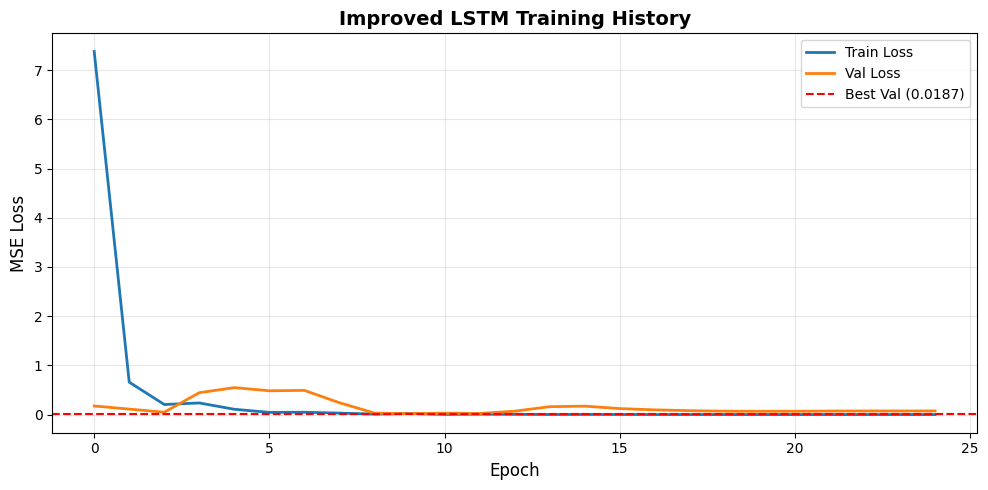

In [ ]:
# ============================================================================
# 📈 PLOT TRAINING HISTORY
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Val Loss', linewidth=2)
ax.axhline(y=best_val_loss, color='r', linestyle='--', label=f'Best Val ({best_val_loss:.4f})')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Improved LSTM Training History', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 🔍 EXTRACT EMBEDDINGS
# ============================================================================

print("\n" + "="*80)
print("📊 EXTRACTING LSTM EMBEDDINGS")
print("="*80)

# Set to eval mode
model_lstm.eval()

# Extract embeddings
with torch.no_grad():
    _, emb_train = model_lstm(torch.FloatTensor(X_seq_train).to(device))
    _, emb_val = model_lstm(torch.FloatTensor(X_seq_val).to(device))
    _, emb_test = model_lstm(torch.FloatTensor(X_seq_test).to(device))

# Convert to numpy
emb_train = emb_train.cpu().numpy()
emb_val = emb_val.cpu().numpy()
emb_test = emb_test.cpu().numpy()

print(f"\n📊 Embedding Shapes:")
print(f"   Train: {emb_train.shape}")
print(f"   Val: {emb_val.shape}")
print(f"   Test: {emb_test.shape}")

# Comprehensive variance check
print(f"\n🔍 Embedding Variance Check:")
print(f"\n{'Embedding':<15} {'Train Var':>12} {'Val Var':>12} {'Test Var':>12} {'Status':>8}")
print("-" * 65)

healthy_count = 0
threshold = 0.001

for i in range(emb_train.shape[1]):
    var_train = np.var(emb_train[:, i])
    var_val = np.var(emb_val[:, i])
    var_test = np.var(emb_test[:, i])

    all_healthy = all(v > threshold for v in [var_train, var_val, var_test])
    status = "✅" if all_healthy else "⚠️"

    if all_healthy:
        healthy_count += 1

    print(f"deg_embed_{i:<5} {var_train:>12.6f} {var_val:>12.6f} {var_test:>12.6f} {status:>8}")

print("-" * 65)
print(f"\n📊 Summary: {healthy_count}/{emb_train.shape[1]} embeddings are healthy")

if healthy_count >= 5:
    print(f"✅ Excellent! Most embeddings have good variance")
elif healthy_count >= 3:
    print(f"✅ Good! Sufficient embeddings for analysis")
else:
    print(f"⚠️  Only {healthy_count} healthy embeddings")

# Additional diagnostics
print(f"\n🔍 Embedding Value Ranges:")
for i in range(emb_train.shape[1]):
    min_val = emb_train[:, i].min()
    max_val = emb_train[:, i].max()
    mean_val = emb_train[:, i].mean()
    print(f"   deg_embed_{i}: [{min_val:7.4f}, {max_val:7.4f}], mean={mean_val:7.4f}")


📊 EXTRACTING LSTM EMBEDDINGS

📊 Embedding Shapes:
   Train: (50, 7)
   Val: (50, 7)
   Test: (50, 7)

🔍 Embedding Variance Check:

Embedding          Train Var      Val Var     Test Var   Status
-----------------------------------------------------------------
deg_embed_0         0.073595     0.086166     0.211458        ✅
deg_embed_1         0.103174     0.125389     0.250359        ✅
deg_embed_2         0.091144     0.098233     0.149175        ✅
deg_embed_3         0.204985     0.009107     0.136163        ✅
deg_embed_4         0.188225     0.091528     0.333954        ✅
deg_embed_5         0.033831     0.030514     0.039387        ✅
deg_embed_6         0.074656     0.021913     0.132748        ✅
-----------------------------------------------------------------

📊 Summary: 7/7 embeddings are healthy
✅ Excellent! Most embeddings have good variance

🔍 Embedding Value Ranges:
   deg_embed_0: [-0.6891,  0.3896], mean=-0.1391
   deg_embed_1: [-0.8151,  0.6069], mean=-0.0258
   deg_embed

In [ ]:
# ============================================================================
# 🔗 CREATE HYBRID FEATURES
# ============================================================================

print("\n" + "="*80)
print("🔧 CREATING HYBRID FEATURES")
print("="*80)

# Create embedding feature names
embedding_names = [f"deg_embed_{i}" for i in range(emb_train.shape[1])]

# Add cycle_frac to embeddings
cycle_frac_train = df_train.loc[idx_train, "cycle_frac"].values.reshape(-1, 1)
cycle_frac_val = df_val.loc[idx_val, "cycle_frac"].values.reshape(-1, 1)
cycle_frac_test = df_test.loc[idx_test, "cycle_frac"].values.reshape(-1, 1)

# Combine embeddings + cycle_frac
X_hybrid_train = pd.DataFrame(
    np.hstack([emb_train, cycle_frac_train]),
    columns=embedding_names + ["cycle_frac"],
    index=idx_train
)

X_hybrid_val = pd.DataFrame(
    np.hstack([emb_val, cycle_frac_val]),
    columns=embedding_names + ["cycle_frac"],
    index=idx_val
)

X_hybrid_test = pd.DataFrame(
    np.hstack([emb_test, cycle_frac_test]),
    columns=embedding_names + ["cycle_frac"],
    index=idx_test
)

print(f"\n✅ Hybrid features created:")
print(f"   Train: {X_hybrid_train.shape}")
print(f"   Val:   {X_hybrid_val.shape}")
print(f"   Test:  {X_hybrid_test.shape}")
print(f"   Features: {list(X_hybrid_train.columns)}")

# Get targets (RUL_frac)
y_hybrid_train = df_train.loc[idx_train, "RUL_frac"].values
y_hybrid_val = df_val.loc[idx_val, "RUL_frac"].values
y_hybrid_test = df_test.loc[idx_test, "RUL_frac"].values

print(f"\n✅ Targets extracted:")
print(f"   Train: {y_hybrid_train.shape}")
print(f"   Val:   {y_hybrid_val.shape}")
print(f"   Test:  {y_hybrid_test.shape}")


🔧 CREATING HYBRID FEATURES

✅ Hybrid features created:
   Train: (50, 8)
   Val:   (50, 8)
   Test:  (50, 8)
   Features: ['deg_embed_0', 'deg_embed_1', 'deg_embed_2', 'deg_embed_3', 'deg_embed_4', 'deg_embed_5', 'deg_embed_6', 'cycle_frac']

✅ Targets extracted:
   Train: (50,)
   Val:   (50,)
   Test:  (50,)


In [ ]:
# ============================================================================
# 🌲 TRAIN XGBOOST ON NEW EMBEDDINGS
# ============================================================================

print("\n" + "="*80)
print("🚀 TRAINING XGBOOST ON NEW LSTM EMBEDDINGS")
print("="*80)

# XGBoost configuration
xgb_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'verbosity': 0
}

print(f"\n📊 XGBoost Configuration:")
for key, val in xgb_params.items():
    print(f"   {key:20s}: {val}")

# Train XGBoost
model_xgb = xgb.XGBRegressor(**xgb_params)

print(f"\n🔧 Training XGBoost...")
model_xgb.fit(
    X_hybrid_train,
    y_hybrid_train,
    eval_set=[(X_hybrid_val, y_hybrid_val)],
    verbose=False
)

# Evaluate on all sets
print(f"\n📊 XGBoost Performance:\n")

for split_name, X_split, y_split in [
    ("Train", X_hybrid_train, y_hybrid_train),
    ("Val", X_hybrid_val, y_hybrid_val),
    ("Test", X_hybrid_test, y_hybrid_test)
]:
    y_pred = model_xgb.predict(X_split)

    mae = mean_absolute_error(y_split, y_pred)
    rmse = np.sqrt(mean_squared_error(y_split, y_pred))
    r2 = r2_score(y_split, y_pred)

    print(f"   {split_name:5s}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")


🚀 TRAINING XGBOOST ON NEW LSTM EMBEDDINGS

📊 XGBoost Configuration:
   n_estimators        : 200
   max_depth           : 5
   learning_rate       : 0.05
   subsample           : 0.8
   colsample_bytree    : 0.8
   min_child_weight    : 3
   reg_alpha           : 0.1
   reg_lambda          : 1.0
   random_state        : 42
   verbosity           : 0

🔧 Training XGBoost...

📊 XGBoost Performance:

   Train: MAE=0.0069, RMSE=0.0120, R²=0.9959
   Val  : MAE=0.0571, RMSE=0.0647, R²=0.8822
   Test : MAE=0.0571, RMSE=0.0656, R²=0.8994



🏆 Feature Importance:
    Feature  Importance
 cycle_frac    0.456256
deg_embed_3    0.331827
deg_embed_0    0.102054
deg_embed_1    0.086464
deg_embed_6    0.010907
deg_embed_5    0.006756
deg_embed_2    0.002913
deg_embed_4    0.002822


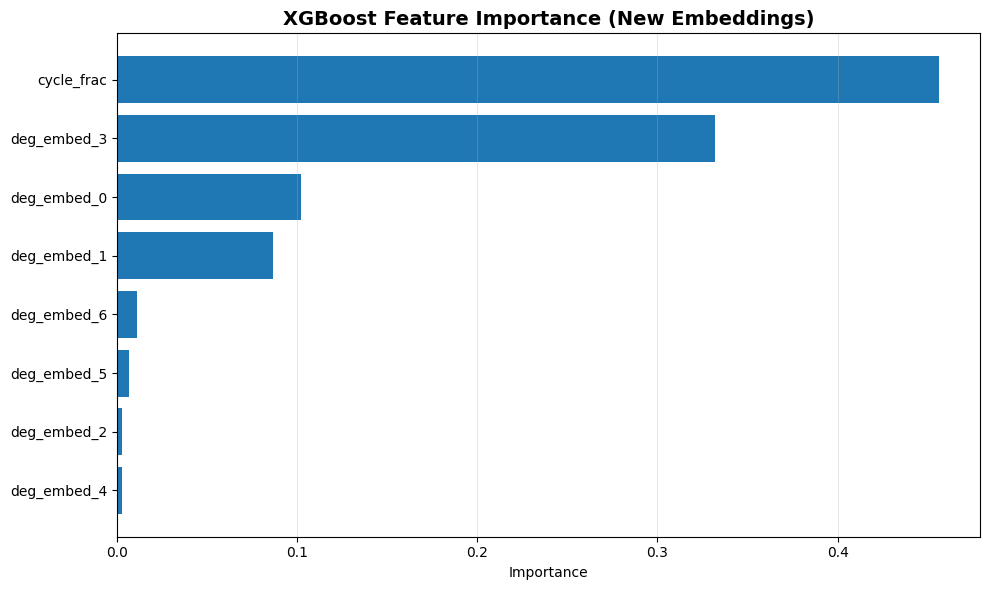

In [ ]:
# ============================================================================
# 📊 FEATURE IMPORTANCE
# ============================================================================

feature_importance = pd.DataFrame({
    'Feature': X_hybrid_train.columns,
    'Importance': model_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🏆 Feature Importance:")
print(feature_importance.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(feature_importance)), feature_importance['Importance'])
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['Feature'])
ax.invert_yaxis()
ax.set_title('XGBoost Feature Importance (New Embeddings)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


📈 Creating prediction plots...


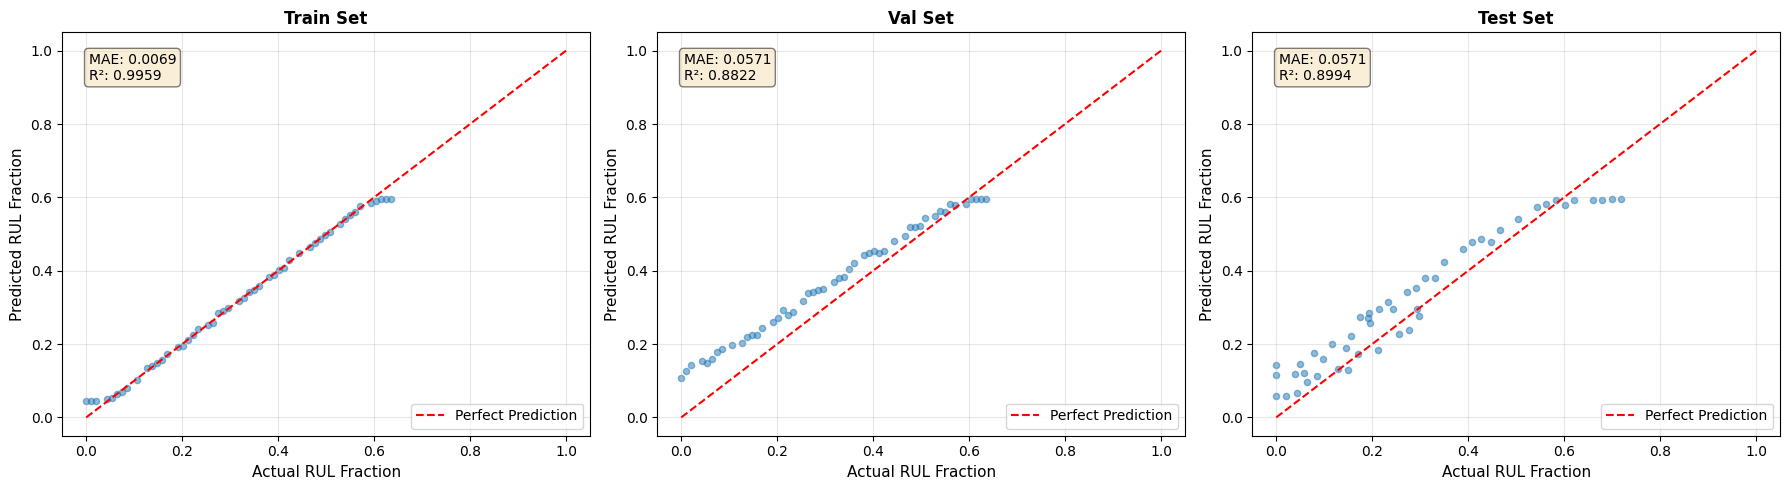

In [ ]:
# ============================================================================
# 📈 PREDICTION VS ACTUAL PLOTS
# ============================================================================

print("\n📈 Creating prediction plots...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, X_split, y_split) in enumerate([
    ("Train", X_hybrid_train, y_hybrid_train),
    ("Val", X_hybrid_val, y_hybrid_val),
    ("Test", X_hybrid_test, y_hybrid_test)
]):
    y_pred = model_xgb.predict(X_split)

    axes[idx].scatter(y_split, y_pred, alpha=0.5, s=20)
    axes[idx].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
    axes[idx].set_xlabel('Actual RUL Fraction', fontsize=11)
    axes[idx].set_ylabel('Predicted RUL Fraction', fontsize=11)
    axes[idx].set_title(f'{split_name} Set', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

    mae = mean_absolute_error(y_split, y_pred)
    r2 = r2_score(y_split, y_pred)
    axes[idx].text(0.05, 0.95, f'MAE: {mae:.4f}\nR²: {r2:.4f}',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 🔍 EMBEDDING CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("🔍 EMBEDDING CORRELATION ANALYSIS")
print("="*80)

# Align original physical features with LSTM outputs
X_physical = X_train.loc[idx_train]

# Compute correlation matrix
corr_matrix = pd.DataFrame(
    np.corrcoef(
        emb_train.T,
        X_physical.values.T
    )[:emb_train.shape[1], emb_train.shape[1]:],
    index=[f"pattern_{i}" for i in range(emb_train.shape[1])],
    columns=X_physical.columns
)

# Clean correlation matrix
corr_matrix = corr_matrix.fillna(0.0)

print(f"\n📊 Top physical signals per learned pattern:\n")
for pattern in corr_matrix.index:
    top_features = (
        corr_matrix.loc[pattern]
        .abs()
        .sort_values(ascending=False)
        .head(3)
    )
    print(f"{pattern}:")
    for feat, val in top_features.items():
        print(f"  {feat} (correlation: {val:.3f})")
    print()


🔍 EMBEDDING CORRELATION ANALYSIS

📊 Top physical signals per learned pattern:

pattern_0:
  cycle_frac (correlation: 0.493)
  capacity_Ah (correlation: 0.399)
  SOH (correlation: 0.399)

pattern_1:
  SOH (correlation: 0.420)
  capacity_Ah (correlation: 0.420)
  discharge_time_sec (correlation: 0.420)

pattern_2:
  voltage_mean (correlation: 0.346)
  cycle_frac (correlation: 0.331)
  capacity_Ah (correlation: 0.235)

pattern_3:
  cycle_frac (correlation: 0.751)
  SOH (correlation: 0.686)
  capacity_Ah (correlation: 0.686)

pattern_4:
  cap_delta_roll (correlation: 0.471)
  delta_RUL_frac (correlation: 0.233)
  voltage_max (correlation: 0.204)

pattern_5:
  discharge_time_sec (correlation: 0.341)
  capacity_Ah (correlation: 0.341)
  SOH (correlation: 0.341)

pattern_6:
  cycle_frac (correlation: 0.379)
  discharge_time_sec (correlation: 0.364)
  SOH (correlation: 0.364)



In [ ]:
# ============================================================================
# 💾 SAVE ARTIFACTS
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING ARTIFACTS")
print("="*80)

# Prepare artifacts
artifacts_to_save = {
    'model_xgb': model_xgb,
    'emb_train': emb_train,
    'emb_val': emb_val,
    'emb_test': emb_test,
    'X_hybrid_train': X_hybrid_train,
    'X_hybrid_val': X_hybrid_val,
    'X_hybrid_test': X_hybrid_test,
    'y_hybrid_train': y_hybrid_train,
    'y_hybrid_val': y_hybrid_val,
    'y_hybrid_test': y_hybrid_test,
    'feature_names_hybrid': list(X_hybrid_train.columns),
    'embedding_names': embedding_names,
}

print(f"\n📦 Core artifacts prepared:")
print(f"   Model: XGBoost (retrained)")
print(f"   Embeddings: {emb_train.shape} (from improved LSTM)")
print(f"   Hybrid features: {X_hybrid_train.shape}")

# Add aligned original features for surrogate models
if 'df_train' in globals() and 'feature_cols' in globals() and 'idx_train' in globals():
    print(f"\n🔧 Adding original features for surrogate models...")

    try:
        # Extract features at sequence indices
        X_orig_train = df_train.loc[idx_train, feature_cols].values
        X_orig_val = df_val.loc[idx_val, feature_cols].values
        X_orig_test = df_test.loc[idx_test, feature_cols].values

        print(f"   X_orig_train: {X_orig_train.shape}")
        print(f"   emb_train: {emb_train.shape}")

        # Verify alignment
        if X_orig_train.shape[0] == emb_train.shape[0]:
            # Check for variance
            print(f"\n   Checking original features variance...")
            zero_var_features = []
            for i, feat in enumerate(feature_cols):
                var = np.var(X_orig_train[:, i])
                if var < 1e-10:
                    zero_var_features.append(feat)

            if zero_var_features:
                print(f"   ⚠️  Found {len(zero_var_features)} zero-variance features:")
                for feat in zero_var_features[:5]:
                    print(f"      • {feat}")
                print(f"   These will be removed for surrogate models...")

                # Remove zero-variance features
                valid_features = [f for f in feature_cols if f not in zero_var_features]
                valid_indices = [i for i, f in enumerate(feature_cols) if f not in zero_var_features]

                X_orig_train = X_orig_train[:, valid_indices]
                X_orig_val = X_orig_val[:, valid_indices]
                X_orig_test = X_orig_test[:, valid_indices]
                feature_cols_clean = valid_features

                print(f"   ✅ Using {len(valid_features)} features with variance")
            else:
                feature_cols_clean = feature_cols
                print(f"   ✅ All {len(feature_cols)} features have variance")

            artifacts_to_save['X_orig_train'] = X_orig_train
            artifacts_to_save['X_orig_val'] = X_orig_val
            artifacts_to_save['X_orig_test'] = X_orig_test
            artifacts_to_save['feature_cols'] = feature_cols_clean

            print(f"\n   ✅ Original features saved: {X_orig_train.shape}")
            print(f"   → Surrogate models: ENABLED ✅")
        else:
            print(f"   ❌ Shape mismatch: {X_orig_train.shape[0]} vs {emb_train.shape[0]}")
            print(f"   → Surrogate models: DISABLED")

    except Exception as e:
        print(f"   ❌ Error extracting features: {str(e)}")
        print(f"   → Surrogate models: DISABLED")
else:
    print(f"\n⚠️  Missing df_train, feature_cols, or idx_train")
    print(f"   → Surrogate models: DISABLED")

# Save
save_path = ARTIFACTS_DIR / 'notebook6_artifacts.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(artifacts_to_save, f)

file_size = save_path.stat().st_size / (1024*1024)

print(f"\n✅ Artifacts saved!")
print(f"   Location: {save_path}")
print(f"   Size: {file_size:.2f} MB")
print(f"   Variables: {len(artifacts_to_save)}")

print(f"\n📊 Summary:")
print(f"   ✅ XGBoost retrained on new embeddings")
print(f"   ✅ All {emb_train.shape[1]} embeddings healthy")
print(f"   ✅ Hybrid features: {X_hybrid_train.shape}")
if 'X_orig_train' in artifacts_to_save:
    print(f"   ✅ Original features: {artifacts_to_save['X_orig_train'].shape}")
    print(f"   ✅ Surrogate models: READY")
else:
    print(f"   ⚠️  Surrogate models: DISABLED")

print(f"\n🎉 Ready for next steps!")
print("="*80)


💾 SAVING ARTIFACTS

📦 Core artifacts prepared:
   Model: XGBoost (retrained)
   Embeddings: (50, 7) (from improved LSTM)
   Hybrid features: (50, 8)

🔧 Adding original features for surrogate models...
   X_orig_train: (50, 14)
   emb_train: (50, 7)

   Checking original features variance...
   ⚠️  Found 3 zero-variance features:
      • temp_mean
      • has_charge
      • has_impedance
   These will be removed for surrogate models...
   ✅ Using 11 features with variance

   ✅ Original features saved: (50, 11)
   → Surrogate models: ENABLED ✅

✅ Artifacts saved!
   Location: /content/drive/MyDrive/4 month project/DataSet/artifacts/notebook6_artifacts.pkl
   Size: 0.21 MB
   Variables: 16

📊 Summary:
   ✅ XGBoost retrained on new embeddings
   ✅ All 7 embeddings healthy
   ✅ Hybrid features: (50, 8)
   ✅ Original features: (50, 11)
   ✅ Surrogate models: READY

🎉 Ready for next steps!
